### S3링크로 이미지 불러오기

In [58]:
from urllib import request
from PIL import Image
import urllib.request
import time
from io import BytesIO

url = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/9d3276c2-5aca-4416-bd67-400a8b421f69.png"

# time check
start = time.time()

# request.urlopen()
# HTTP Error 403: Forbidden 에러 때문에 하단의 소스 한 줄을 추가해주었다.
req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
res = request.urlopen(req).read()

# 이미지 다운로드 시간 체크
print(time.time() - start)

# Image open
urlopen_img = Image.open(BytesIO(res))

1.1788349151611328


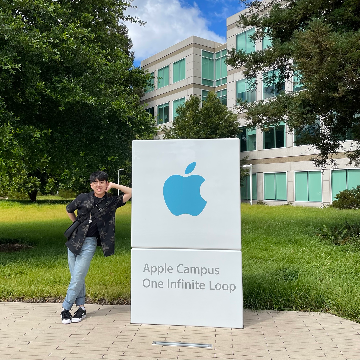

In [60]:
urlopen_img

### 블랙 박스 영역 지정

In [68]:
import cv2 as cv2
import numpy as np
import urllib
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# // 비교 알고리즘의 이름들을 리스트에 저장
methods = ['CORREL',  # cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
           'CHISQR',  # cv2.HISTCMP_CHISQR: 카이제곱 (0: 완전 일치, 무한대: 완전 불일치)
           'INTERSECT',  # cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
           'BHATTACHARYYA',  # cv2.HISTCMP_BHATTACHARYYA 값이 작을수록 유사한 것으로 판단
           'EMD'
           ]

mission = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/40942aa9-02f1-4ab5-a483-2163b7c6c45c.png"
success = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/9d3276c2-5aca-4416-bd67-400a8b421f69.png"
fail = "https://findspot.s3.ap-northeast-2.amazonaws.com/static/c802a2c8-3441-4fa8-8c28-448799e4efaa.png"

knn = KNeighborsClassifier(n_neighbors=1)


def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = image[135:330, 130:245].copy()  # 세로, 가로
    return image


def check_simular(mission, trial):
    # 이미지 읽어오기
    imgs = [url_to_image(mission), url_to_image(trial)]

    hists = []
    grays = []
    for img in imgs:
        hists.append(image_to_hsv(img))
        grays.append(image_to_gray(img))

    result = [
        cv2.compareHist(hists[0], hists[1], 0),
        cv2.compareHist(hists[0], hists[1], 2) / np.sum(hists[0]),
        cv2.compareHist(hists[0], hists[1], 3),
        ssim(grays[0], grays[1], full=True)
    ]
    # cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
    # cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
    # cv2.HISTCMP_BHATTACHARYYA 값이 작을수록 유사한 것으로 판단
    # ssim 1에 근접할 수록 유사한 이미지

    print(result[0], result[1], result[2], result[3][0])

    return result[0] + result[1] - result[2], result[3][0]


def image_to_hsv(img):
    # BGR 이미지를 HSV 이미지로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = cv2.resize(hsv, dsize=(360, 360))
    # 히스토그램 연산(파라미터 순서 : 이미지, 채널, Mask, 크기, 범위)
    hist = cv2.calcHist([hsv], [0, 1], None, [360, 360], [0, 360, 0, 360])
    # 정규화(파라미터 순서 : 정규화 전 데이터, 정규화 후 데이터, 시작 범위, 끝 범위, 정규화 알고리즘)
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    # hists 리스트에 저장
    return hist


def image_to_gray(img):
    # // BGR 이미지를 GRAY 이미지로 변환
    img = cv2.resize(img, [360, 360])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray


def analyze(data, classes):
    knn.fit(data, classes)

In [69]:
x = []
y = []
classes = [0, 0, 1]

def insert(mission, trial):
    data = check_simular(mission, trial)
    x.append(data[0])
    y.append(data[1])

insert(mission, mission)
insert(mission, success)
insert(mission, fail)

1.0 1.0000000110144858 0.0 1.0
0.36163733340981563 0.3862098270190903 0.7140566444395303 0.6840475784276361
0.03799426199798938 0.3897573139742826 0.8992775986527417 0.16494865325459615


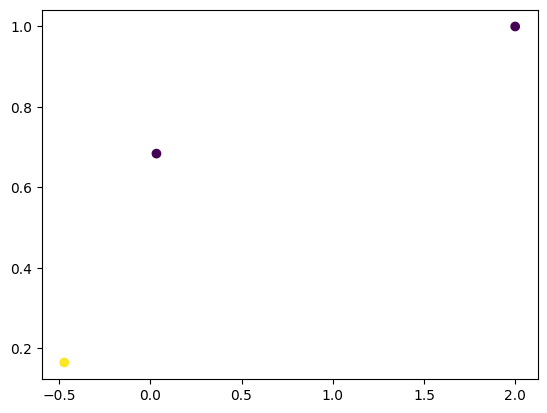

In [70]:
plt.scatter(x, y, c=classes)
plt.show()

In [73]:
predict = analyze(list(zip(x, y)), classes)
data = check_simular(mission, "https://findspot.s3.ap-northeast-2.amazonaws.com/static/0c169417-ce42-4602-930e-2e6111ef9390.png")

pred = knn.predict([data])
print(pred)

0.009474835585157075 0.1710644149442681 0.8903560268280334 0.22903803813010484
[1]
